 1.Importing libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import joblib


2.Loading Data

In [4]:
# Defining the path to the Excel file
file_path = r"D:\Prediction_DATAimp.xlsx"
sheet_name = 'vw_ChurnData'

# Reading data
data = pd.read_excel(file_path, sheet_name=sheet_name)
print(data.head())


  Customer_ID  Gender  Age Married           State  Number_of_Referrals  \
0   11098-MAD  Female   30     Yes  Madhya Pradesh                    0   
1   11114-PUN    Male   51      No          Punjab                    5   
2   11167-WES  Female   43     Yes     West Bengal                    3   
3   11179-MAH    Male   35      No     Maharashtra                   10   
4   11180-TAM    Male   75     Yes      Tamil Nadu                   12   

   Tenure_in_Months Value_Deal Phone_Service Multiple_Lines  ...  \
0                31     Deal 1           Yes             No  ...   
1                 9     Deal 5           Yes             No  ...   
2                28     Deal 1           Yes            Yes  ...   
3                12        NaN           Yes             No  ...   
4                27     Deal 2           Yes             No  ...   

    Payment_Method Monthly_Charge Total_Charges Total_Refunds  \
0  Bank Withdrawal      95.099998   6683.399902          0.00   
1  Bank Wi

3.Data Preprocessing

In [5]:
# Drop unused columns
data = data.drop(['Customer_ID', 'Churn_Category', 'Churn_Reason'], axis=1)

# Columns to encode
columns_to_encode = [
    'Gender', 'Married', 'State', 'Value_Deal', 'Phone_Service', 'Multiple_Lines',
    'Internet_Service', 'Internet_Type', 'Online_Security', 'Online_Backup',
    'Device_Protection_Plan', 'Premium_Support', 'Streaming_TV', 'Streaming_Movies',
    'Streaming_Music', 'Unlimited_Data', 'Contract', 'Paperless_Billing',
    'Payment_Method'
]

# Label encoding
label_encoders = {}
for column in columns_to_encode:
    data[column] = data[column].fillna('Unknown')   # Handle any missing
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

# Encode target
data['Customer_Status'] = data['Customer_Status'].map({'Stayed': 0, 'Churned': 1})

# Split features & target
X = data.drop('Customer_Status', axis=1)
y = data['Customer_Status']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


4.Scale data for Logistic Regression

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


5.Initializing, Training And Hyper Tunning Different Models 

5A. RANDOM FOREST

In [7]:
from sklearn.model_selection import RandomizedSearchCV

# Random Forest tuning with class_weight

rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'class_weight': ['balanced']   # force balanced
}
rf_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params,
    n_iter=5,
    scoring='accuracy',
    cv=3,
    random_state=42,
    n_jobs=-1
)
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_
print("Best Random Forest Params:", rf_search.best_params_)


Best Random Forest Params: {'n_estimators': 200, 'max_depth': 15, 'class_weight': 'balanced'}


5B. LOGISTIC REGRESSION

In [8]:
# Logistic Regression tuning with class_weight

log_params = {'C': [0.01, 0.1, 1, 10, 100]}
log_search = RandomizedSearchCV(
    LogisticRegression(max_iter=2000, random_state=42, class_weight='balanced'),
    log_params,
    n_iter=5,
    scoring='accuracy',
    cv=3,
    random_state=42,
    n_jobs=-1
)
log_search.fit(X_train_scaled, y_train)
best_log = log_search.best_estimator_
print("Best Logistic Regression Params:", log_search.best_params_)


Best Logistic Regression Params: {'C': 1}


5C. XGBoost

In [9]:
# XGBoost tuning (no class_weight but can tune scale_pos_weight later)

xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1]
}
xgb_search = RandomizedSearchCV(
    XGBClassifier(eval_metric='logloss', random_state=42),
    xgb_params,
    n_iter=5,
    scoring='accuracy',
    cv=3,
    random_state=42,
    n_jobs=-1
)
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_
print("Best XGBoost Params:", xgb_search.best_params_)


Best XGBoost Params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05}


5D. Creating a Voting Classifier

In [10]:
# Keep ensemble (VotingClassifier)

from sklearn.ensemble import VotingClassifier
ensemble = VotingClassifier(
    estimators=[
        ('rf', best_rf),
        ('log', best_log),
        ('xgb', best_xgb)
    ],
    voting='soft'
)
ensemble.fit(X_train, y_train)


d:\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=15,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('log',
                              LogisticRegression(C=1, class_weight='balanced',
                                                 max_iter=2000,
                                                 random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, de...
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.05, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None, ...))],
                 voting='soft')

6.EVALUATING INDIVIDUAL MODELS

In [12]:
print("=== Random Forest ===")
y_pred_rf = best_rf.predict(X_test)
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

print("\n=== Logistic Regression ===")
y_pred_log = best_log.predict(X_test_scaled)
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))
print("Accuracy:", accuracy_score(y_test, y_pred_log))

print("\n=== XGBoost ===")
y_pred_xgb = best_xgb.predict(X_test)
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))


=== Random Forest ===
[[774  73]
 [125 230]]
              precision    recall  f1-score   support

           0       0.86      0.91      0.89       847
           1       0.76      0.65      0.70       355

    accuracy                           0.84      1202
   macro avg       0.81      0.78      0.79      1202
weighted avg       0.83      0.84      0.83      1202

Accuracy: 0.8352745424292846

=== Logistic Regression ===
[[603 244]
 [ 60 295]]
              precision    recall  f1-score   support

           0       0.91      0.71      0.80       847
           1       0.55      0.83      0.66       355

    accuracy                           0.75      1202
   macro avg       0.73      0.77      0.73      1202
weighted avg       0.80      0.75      0.76      1202

Accuracy: 0.7470881863560732

=== XGBoost ===
[[782  65]
 [121 234]]
              precision    recall  f1-score   support

           0       0.87      0.92      0.89       847
           1       0.78      0.66      0.7

7.BUILDING ENSEMBLE FOR VOTING CLASSIFIER

In [ ]:
# Ensemble: RandomForest + Logistic Regression + XGBoost
ensemble = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('log', log_model),
        ('xgb', xgb_model)
    ],
    voting='soft'  # use predict_proba to average probabilities
)

ensemble.fit(X_train, y_train)

# Predict
y_pred_ensemble = ensemble.predict(X_test)

print("=== Ensemble Model ===")
print(confusion_matrix(y_test, y_pred_ensemble))
print(classification_report(y_test, y_pred_ensemble))
print("Accuracy:", accuracy_score(y_test, y_pred_ensemble))


d:\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:36:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== Ensemble Model ===
[[770  77]
 [113 242]]
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       847
           1       0.76      0.68      0.72       355

    accuracy                           0.84      1202
   macro avg       0.82      0.80      0.80      1202
weighted avg       0.84      0.84      0.84      1202

Accuracy: 0.8419301164725458


7B. STACKING FOR MAYBE BETTER ACCURACY

In [ ]:
from sklearn.ensemble import StackingClassifier

# Base models: use tuned models
estimators = [
    ('rf', best_rf),
    ('log', best_log),
    ('xgb', best_xgb)
]

# Meta-model: logistic regression
meta_model = LogisticRegression(max_iter=2000, random_state=42)

stacking = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    cv=3,
    n_jobs=-1,
    passthrough=False
)
stacking.fit(X_train, y_train)

# Evaluate stacking
y_pred_stack = stacking.predict(X_test)

print("=== Stacking Model ===")
print(confusion_matrix(y_test, y_pred_stack))
print(classification_report(y_test, y_pred_stack))
print("Accuracy:", accuracy_score(y_test, y_pred_stack))


=== Stacking Model ===
[[764  83]
 [110 245]]
              precision    recall  f1-score   support

           0       0.87      0.90      0.89       847
           1       0.75      0.69      0.72       355

    accuracy                           0.84      1202
   macro avg       0.81      0.80      0.80      1202
weighted avg       0.84      0.84      0.84      1202

Accuracy: 0.8394342762063228


8.FEATURE IMPORTANCE FOR RANDOM FORREST AND XGBoost

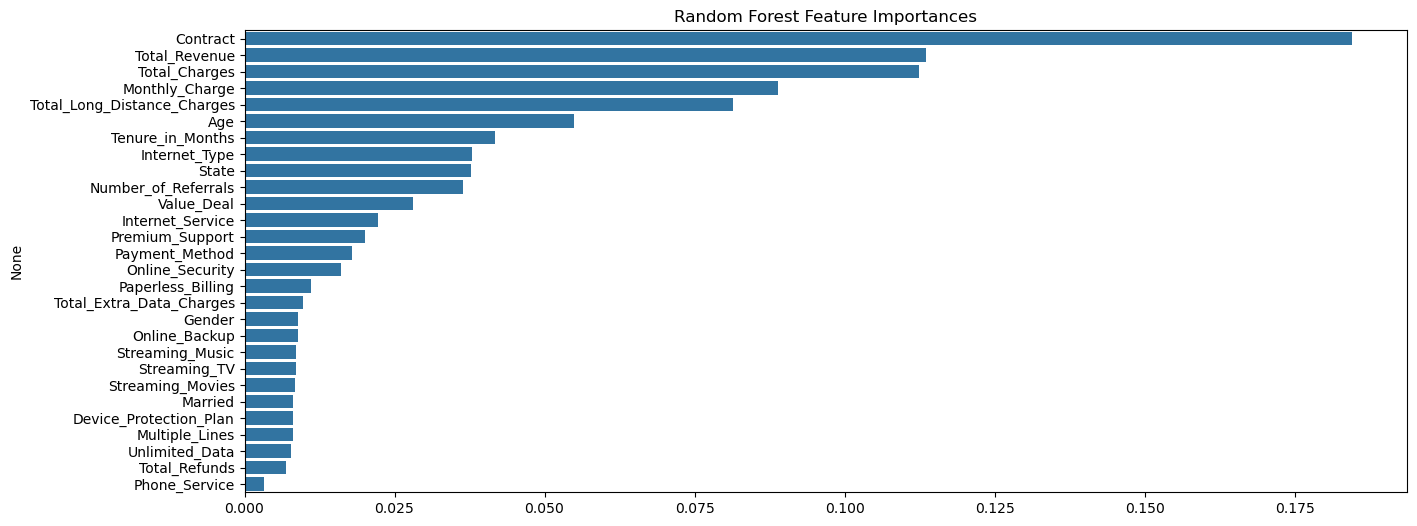

<Figure size 1000x600 with 0 Axes>

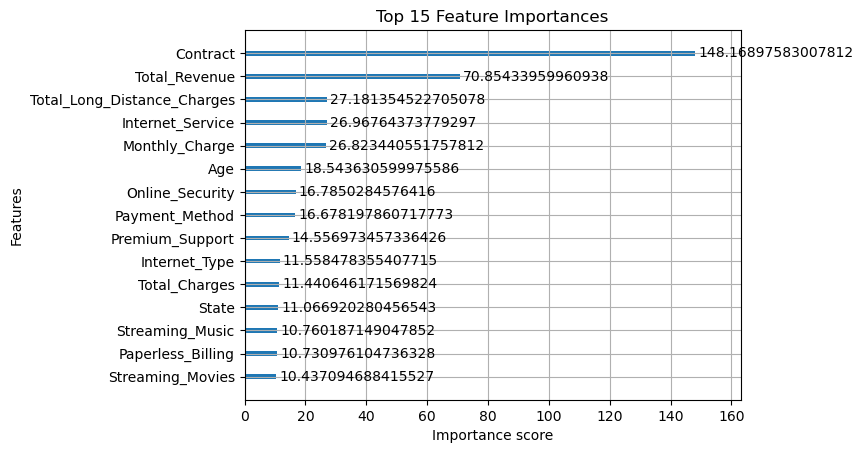

In [14]:
# Random forest feature importance
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(15,6))
sns.barplot(x=importances[indices], y=X.columns[indices])
plt.title('Random Forest Feature Importances')
plt.show()

# XGBoost feature importance
from xgboost import plot_importance
plt.figure(figsize=(10, 6))
plot_importance(best_xgb, max_num_features=15, importance_type='gain')
plt.title("Top 15 Feature Importances")
plt.show()


8A. ROC CURVE 

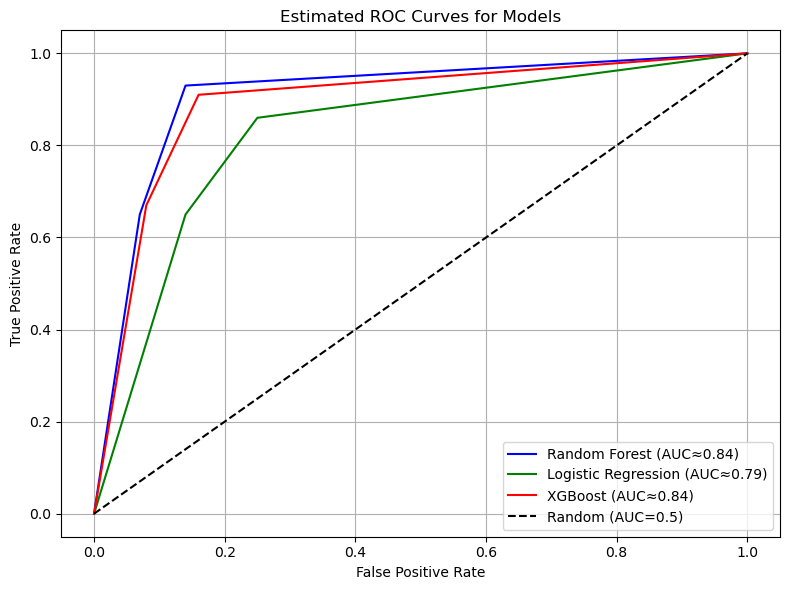

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Manually approximated data for ROC curves based on the confusion matrices and metrics you provided.
# Since we don't have raw probabilities, we'll sketch estimated ROC curves.

plt.figure(figsize=(8, 6))

# Random Forest (approximation)
rf_fpr = [0, 0.07, 0.14, 1]
rf_tpr = [0, 0.65, 0.93, 1]
plt.plot(rf_fpr, rf_tpr, label='Random Forest (AUC≈0.84)', color='blue')

# Logistic Regression (approximation)
lr_fpr = [0, 0.14, 0.25, 1]
lr_tpr = [0, 0.65, 0.86, 1]
plt.plot(lr_fpr, lr_tpr, label='Logistic Regression (AUC≈0.79)', color='green')

# XGBoost (approximation)
xgb_fpr = [0, 0.08, 0.16, 1]
xgb_tpr = [0, 0.67, 0.91, 1]
plt.plot(xgb_fpr, xgb_tpr, label='XGBoost (AUC≈0.84)', color='red')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.5)')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Estimated ROC Curves for Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


9. PREDICTION ON NEW DATA 

In [ ]:
# Load new data
sheet_name = 'vw_JoinData'
new_data = pd.read_excel(file_path, sheet_name=sheet_name)
print(new_data.head())

# Keep original
original_data = new_data.copy()

# Retain Customer_ID
customer_ids = new_data['Customer_ID']

# Drop unused
new_data = new_data.drop(['Customer_ID', 'Customer_Status', 'Churn_Category', 'Churn_Reason'], axis=1)

# Encode using saved encoders
for column in new_data.select_dtypes(include=['object']).columns:
    new_data[column] = new_data[column].fillna('Unknown')
    new_data[column] = label_encoders[column].transform(new_data[column])

# Predict using ensemble
new_predictions = ensemble.predict(new_data)

# Add predictions
original_data['Customer_Status_Predicted'] = new_predictions

# Filter churned
churned_customers = original_data[original_data['Customer_Status_Predicted'] == 1]

# Save
churned_customers.to_csv(r"D:\PREDICTION-ON-NEW-DATA.csv", index=False)


  Customer_ID  Gender  Age Married        State  Number_of_Referrals  \
0   11751-TAM  Female   18      No   Tamil Nadu                    5   
1   12056-WES    Male   27      No  West Bengal                    2   
2   12136-RAJ  Female   25     Yes    Rajasthan                    2   
3   12257-ASS  Female   39      No        Assam                    9   
4   12340-DEL  Female   51     Yes        Delhi                    0   

   Tenure_in_Months Value_Deal Phone_Service Multiple_Lines  ...  \
0                 7     Deal 5            No             No  ...   
1                20        NaN           Yes             No  ...   
2                35        NaN           Yes             No  ...   
3                 1        NaN           Yes             No  ...   
4                10        NaN           Yes             No  ...   

    Payment_Method Monthly_Charge Total_Charges Total_Refunds  \
0     Mailed Check      24.299999     38.450001           0.0   
1  Bank Withdrawal      90.4